<a href="https://colab.research.google.com/github/pypratikyesankar9/NLP_demystified/blob/main/Named_entity_first_cut_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import gc

gc.collect()

135

In [15]:
import pandas as pd
data = pd.read_csv("ner_dataset.csv",encoding="latin1" )

In [16]:
print(data.head())
print()
data.shape

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O



(1048575, 4)

In [17]:
data.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Data Preprocessing

In [18]:
data = data.fillna(method='ffill')

data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()

(47959, 35177, 17)

In [19]:
data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()

(47959, 35177, 17)

In [7]:

!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

============================== Info about spaCy ==============================

spaCy version    3.7.5                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-6.1.85+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.7.1)        



In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from sklearn.svm import SVC


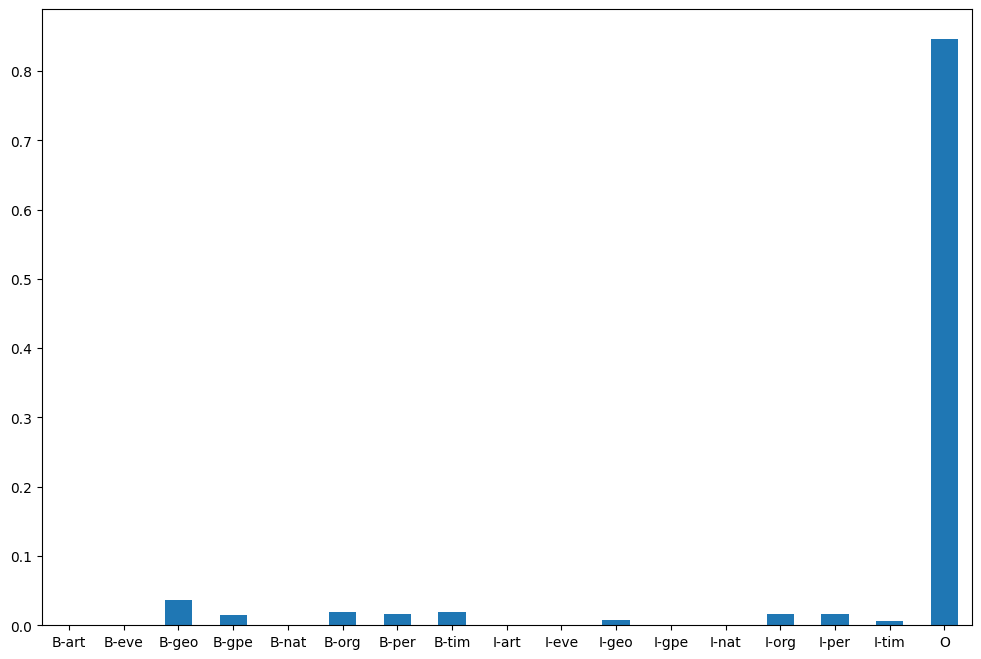

In [22]:

bins, counts = np.unique(data.Tag, return_counts=True)
freq_series = pd.Series(counts/len(data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [23]:
data.groupby('Tag').size().reset_index(name='counts').sort_values(by = 'counts', ascending= False)

,Tag,counts
16,O,887908
2,B-geo,37644
7,B-tim,20333
5,B-org,20143
14,I-per,17251
6,B-per,16990
13,I-org,16784
3,B-gpe,15870
10,I-geo,7414
15,I-tim,6528


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:

data["Sentence #"] = LabelEncoder().fit_transform(data["Sentence #"] )

In [74]:

data.head(30)

,Sentence #,Word,POS,Tag
0,0,Thousands,NNS,O
1,47959,of,IN,O
2,47959,demonstrators,NNS,O
3,47959,have,VBP,O
4,47959,marched,VBN,O
5,47959,through,IN,O
6,47959,London,NNP,B-geo
7,47959,to,TO,O
8,47959,protest,VB,O
9,47959,the,DT,O


In [26]:
data.rename(columns={"Sentence #":"sentence_id","Word":"words","Tag":"labels"}, inplace =True)

In [27]:

data["labels"] = data["labels"].str.upper()

           words
0      Thousands
1             of
2  demonstrators
3           have
4        marched
class of X is :<class 'numpy.ndarray'> 
['words=!' 'words="' 'words=#' ... 'words=\x96' 'words=\x97' 'words=°C']


In [24]:
#print((X.shape))

#print(X[0])

(1048575, 35177)
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
#Y = data.labels.values

#classes = np.unique(Y)
#classes = classes.tolist()

#X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

#X_train.shape, Y_train.shape

In [ ]:
##train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
#test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

#X = df.drop('Tag', axis=1)
#v = DictVectorizer(sparse=False)
#X = v.fit_transform(X.to_dict('records'))
#y = df.Tag.values
#classes = np.unique(y)
#classes = classes.tolist()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
#X_train.shape, y_train.shape

In [28]:

X= data[["sentence_id","words"]]
Y =data["labels"]

In [29]:

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2)

In [15]:
##import pandas as pd
##import numpy as np



In [30]:

#building up train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [32]:
#### Validation data kept separately for final validation
val_data = test_data.copy()

In [33]:
X2= train_data[["sentence_id","words"]]
Y2 =train_data["labels"]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X2,Y2, test_size =0.2)

In [35]:

#re building the train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [37]:

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)



(671088, 3)
(167772, 3)
(209715, 3)


In [38]:
%%time
vectorizer = TfidfVectorizer(stop_words= "english")

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 58.9 µs


In [39]:
%%time
x= vectorizer.fit_transform(train_data['words'].values.astype('U'))

CPU times: user 2.77 s, sys: 171 ms, total: 2.94 s
Wall time: 2.93 s


In [19]:
y = train_data['labels']

In [20]:
classes = np.unique(y)
classes = classes.tolist()

In [3]:
##Naive Bayes classifier for multinomial models
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(x, y, classes)


NameError: name 'x' is not defined

In [22]:
y_pred = nb.predict(x)

In [23]:
from sklearn.metrics import f1_score
print("F1-score:", f1_score(y,y_pred,average = "macro"))

F1-score: 0.4918622507497185


In [26]:
print(classification_report(y_pred=nb.predict(x), y_true=y, labels = classes))

              precision    recall  f1-score   support

       B-ART       0.92      0.28      0.43       322
       B-EVE       0.64      0.27      0.38       242
       B-GEO       0.80      0.77      0.79     29985
       B-GPE       0.93      0.94      0.93     12581
       B-NAT       0.75      0.19      0.30       162
       B-ORG       0.83      0.40      0.54     16149
       B-PER       0.77      0.74      0.76     13541
       B-TIM       0.88      0.74      0.81     16266
       I-ART       1.00      0.10      0.18       234
       I-EVE       1.00      0.01      0.03       205
       I-GEO       0.78      0.50      0.61      5928
       I-GPE       0.91      0.12      0.22       160
       I-NAT       1.00      0.07      0.13        42
       I-ORG       0.68      0.22      0.33     13355
       I-PER       0.80      0.79      0.79     13805
       I-TIM       0.63      0.09      0.16      5154
           O       0.96      1.00      0.98    710729

    accuracy              

In [1]:
#train svm model
svm = SVC(kernel ='linear', C = 1)

svm.fit(x,y)

NameError: name 'SVC' is not defined

In [ ]:
y_pred = nb.predict(x)

###from sklearn.metrics import f1_score
print("F1-score:", f1_score(y,y_pred,average = "macro"))

In [ ]:
##evaluate model
y_pred = svm.predict(x)


In [ ]:
from sklearn.metrics import f1_score
print("F1-score:", f1_score(y,y_pred,average = "macro"))

In [ ]:
print(metrics.flat_classification_report(y, y_pred, labels = classes))

In [56]:
# X = data.drop(['labels','sentence_id','POS'], axis=1)
# X.head()
# print(X.head())

v = DictVectorizer(sparse=False)


X = train_data.drop(['sentence_id'],axis = 1)

v = DictVectorizer(sparse=False)

x = v.fit_transform(X.to_dict('records'))



##X = v.fit_transform(train_data['words'])

##print("class of X is :{} ".format(type(X)))

##print(v.toarray())

##print(v.get_feature_names_out())

#Y = data.labels.values

#classes = np.unique(Y)
#classes = classes.tolist()

#X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

#X_train.shape, Y_train.shape


In [57]:
print(v.get_feature_names_out())

['labels=B-ART' 'labels=B-EVE' 'labels=B-GEO' ... 'words=\x96'
 'words=\x97' 'words=°C']


In [62]:
print(x.shape)

print(max(x[0]))

(838860, 32040)
1.0
